## Linear classification
    - 102 epochs initial (kmeans)
    - 200 additional epochs (kmeans)
    - train data:
    
```
Haus8 sgRNA #1	190219_195942-V	B12	
Haus8 sgRNA #2	190219_195942-V	E1	
Haus8 sgRNA #3	190219_195942-V	F2	
Haus8 sgRNA #4	190219_195942-V	G2	
DyncH1 sgRNA #3	190219_195942-V	A1	
Incenp sgRNA #1	190219_195942-V	G4	
Incenp sgRNA #2	190219_195942-V	G6	
Incenp sgRNA #3	190219_195942-V	H1	
Rad21 sgRNA #1	190219_195942-V	H3	
Rad21 sgRNA #2	190219_195942-V	H5	
Rad21 sgRNA #3	190219_195942-V	H7
```
Classifier was then built on curated data with train/val/test split = 0.7/0.2/0.1.  


#### Deployment  
Incenp sgRNA #1    190219_195942-V    G5    
Incenp sgRNA #2    190219_195942-V    G8    
No sgRNA Pt11_r02_c12


In [1]:
import time
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable
from util import load_model
from util import AverageMeter, Logger, UnifLabelSampler
import seaborn as sn
import pandas as pd
from glob import glob
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import cv2
import re

In [2]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

### Import data

In [3]:
data_dir = '/home/aogorodnikov/eval'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
tra = [transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       normalize]
dataset = ImageFolderWithPaths(data_dir, transform=transforms.Compose(tra))
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=256,
                                         num_workers=8,
                                         shuffle=True,
                                         pin_memory=True)

len(dataset)

203428

In [4]:
# Class labels
with open("/home/aogorodnikov/classes.txt", 'r') as f:
    classes = f.read().splitlines()

### Import model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model=load_model('/home/aogorodnikov/kmeans100_linear_classif_imagenet/model_best.pth.tar')
# freeze some layers
for param in model.features.parameters():
    param.requires_grad = False
    
criterion = nn.CrossEntropyLoss().cuda()

=> loading checkpoint '/home/aogorodnikov/kmeans100_linear_classif_imagenet/model_best.pth.tar'
Loaded


In [7]:
model.cuda()
model


AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(384, 256, kernel_si

### Test function

In [8]:
def test(model, criterion):
# monitor test loss and accuracy
    image = []
    ground = []
    pred_class = []
    running_loss = 0.
    running_corrects = 0.
    total = 0.
    with torch.no_grad():
        for batch_idx, (data, labels, path) in enumerate(dataloader):
            # move to GPU
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # statistics
            running_loss += loss.item() * data.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += data.size(0)
            
            image.extend(path)
            ground.extend(labels.tolist())
            pred_class.extend(preds.tolist())
            
    tot_loss = running_loss / len(dataset)
    tot_acc = running_corrects.double() / len(dataset)
            
    print('Test Loss: {:.6f}\n'.format(tot_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * tot_acc, running_corrects, total))
    return [image, ground, pred_class]

In [9]:
%%time
lol = test(model, criterion)

Test Loss: 18.577528


Test Accuracy:  0% (1248/203428)
CPU times: user 2min 6s, sys: 2min 35s, total: 4min 42s
Wall time: 4min 18s


In [10]:
len(lol[2])

203428

### Visualization of labels and precitions

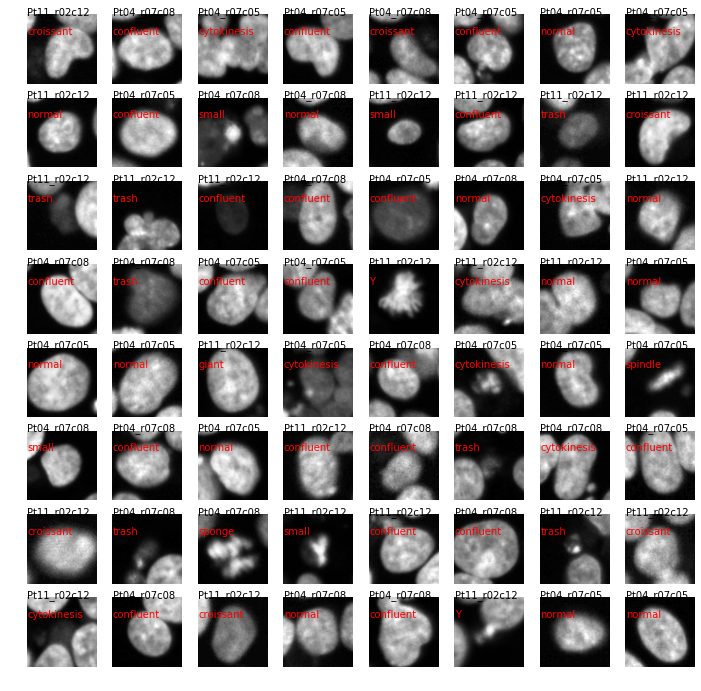

In [11]:
fig=plt.figure(figsize=(12, 12))
columns = 8
rows = 8
for k in range(1, columns * rows + 1):
    rand_select = np.random.choice(range(1, len(lol[0])))
    samp_name = re.search(r'Pt\d+_r\d+c\d+', lol[0][rand_select])[0]
    img_plot = lol[0][rand_select]
    img_import = cv2.imread(img_plot, -1)
    fig.add_subplot(rows, columns, k)
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')
    plt.text(0, 0, s=samp_name)
    plt.text(0, 20, s=classes[lol[2][rand_select]], color='red')
    plt.axis('off')
plt.show()

In [12]:
wells = []
for i in lol[0]:
    wells.append(re.search(r'Pt\d+_r\d+c\d+', i)[0])

In [13]:
lol_df = pd.DataFrame({"image": lol[0], "well": wells, "clust": lol[2]})
lol_df.head()

,image,well,clust
0,/home/aogorodnikov/eval/data/Pt04_r07c05_f22_0...,Pt04_r07c05,2
1,/home/aogorodnikov/eval/data/Pt11_r02c12_f46_1...,Pt11_r02c12,5
2,/home/aogorodnikov/eval/data/Pt11_r02c12_f17_0...,Pt11_r02c12,5
3,/home/aogorodnikov/eval/data/Pt11_r02c12_f28_0...,Pt11_r02c12,5
4,/home/aogorodnikov/eval/data/Pt11_r02c12_f79_0...,Pt11_r02c12,5


In [14]:
clust_ls = []
for well in lol_df.well.unique():
    sum_well = len(lol_df.clust[lol_df.well == well])
    for i in lol_df.clust.unique():
        res = [well, i, len(lol_df.clust[(lol_df.clust == i) & (lol_df.well == well)]) / sum_well * 1e4]
        clust_ls.append(res)

In [15]:
clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])
max_ratios = []
for clust in clust_df['class'].unique():
    ns_ctrl = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt11_r02c12"), "n_samp"]
    ns_pos1 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c05"), "n_samp"]
    ns_pos2 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c08"), "n_samp"]
    max_ratios.append(max([ns_pos1.iloc[0]/ns_ctrl.iloc[0], ns_pos2.iloc[0]/ns_ctrl.iloc[0]]))

In [16]:
clust_df

,well,class,n_samp
0,Pt04_r07c05,2,718.493481
1,Pt04_r07c05,5,2943.666506
2,Pt04_r07c05,6,422.501207
3,Pt04_r07c05,9,946.724610
4,Pt04_r07c05,8,684.371479
5,Pt04_r07c05,1,2091.260261
6,Pt04_r07c05,7,527.925318
7,Pt04_r07c05,3,1040.399163
8,Pt04_r07c05,4,549.171093
9,Pt04_r07c05,0,75.486882


In [17]:
max_ratios


[1.382089295621107,
 0.9114330266570844,
 0.9327326230782006,
 1.0892335214291398,
 1.4694261288966606,
 0.9135752031516817,
 1.1588445372473928,
 1.6914313891465134,
 1.837555038832251,
 1.4839253268236852]

In [18]:
classes

['Y',
 'confluent',
 'croissant',
 'cytokinesis',
 'giant',
 'normal',
 'small',
 'spindle',
 'sponge',
 'trash']

In [19]:
clust_df['class'].unique()

array([2, 5, 6, 9, 8, 1, 7, 3, 4, 0])

In [24]:
cytokinesis = lol_df.loc[(lol_df['clust'] == 3) & (lol_df['well'] == "Pt11_r02c12"), 'image'].tolist()

### Visualization of negative ctrl

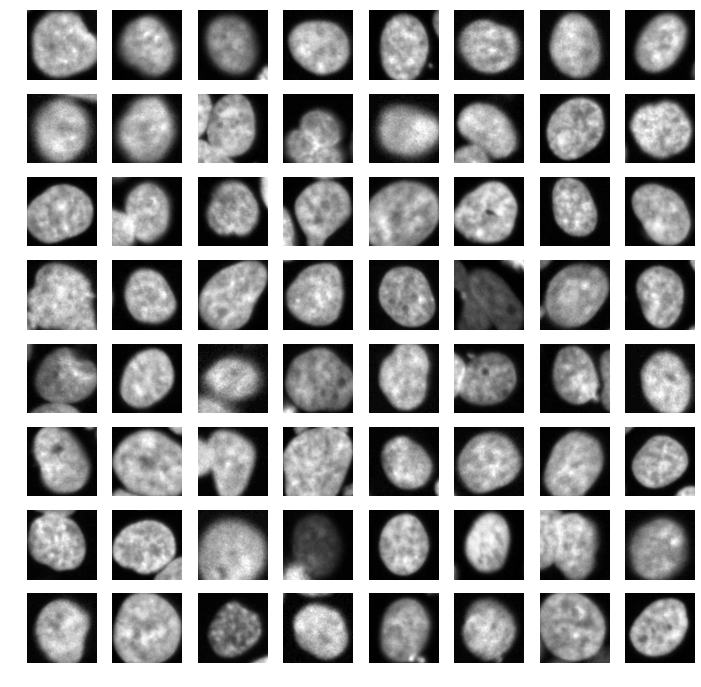

In [23]:
fig=plt.figure(figsize=(12, 12))
columns = 8
rows = 8
for k in range(1, columns * rows + 1):
    rand_select = np.random.choice(range(1, len(cytokinesis)))
    samp_name = re.search(r'Pt\d+_r\d+c\d+', cytokinesis[rand_select])[0]
    img_plot = cytokinesis[rand_select]
    img_import = cv2.imread(img_plot, -1)
    fig.add_subplot(rows, columns, k)
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')
plt.show()